In [1]:
%matplotlib inline

import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

In [2]:
image = 'img/lenna.png'
weight_image = 'img/weights.png'

img = cv2.imread(image)
data = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

weights = cv2.imread(weight_image)
weights = cv2.cvtColor(weights, cv2.COLOR_BGR2GRAY)
weights_vec = weights.reshape(weights.size).astype(float) / np.sum(weights)

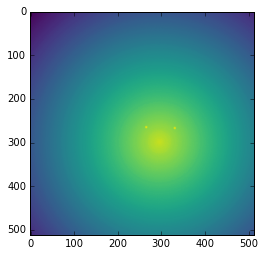

In [3]:
plt.imshow(weights, cmap='viridis')

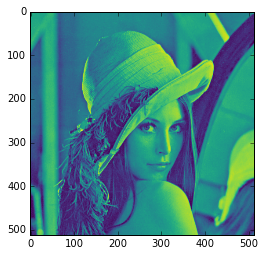

In [4]:
plt.imshow(data, cmap='viridis')

In [5]:
sample_size = 10000

def get_sample():
    data_vec = data.reshape(data.size)
    indexes = np.random.choice(np.arange(data.size), sample_size, p=weights_vec, replace=False)
    coordinates = np.unravel_index(indexes, data.shape)

    values = data_vec[indexes]
    # print coordinates, values
    
    return coordinates, values

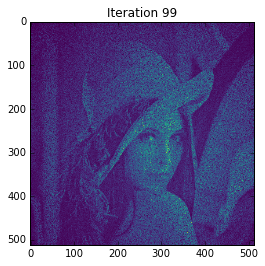

Done


In [6]:
curr_counts = np.zeros(data.shape)
curr_values = np.zeros(data.shape)
# curr_stdevs = np.zeros(data.shape)

for iteration in range(100):
    coordinates, values = get_sample()

    curr_counts[coordinates] += 1
    curr_values[coordinates] += values

    display.clear_output(wait=True)
    plt.title('Iteration {}'.format(iteration))
    plt.imshow(curr_values, cmap='viridis')
    plt.show()
print "Done"

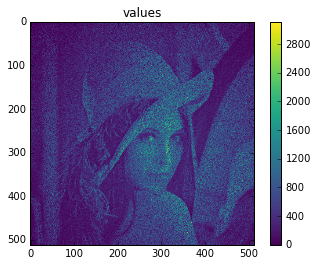

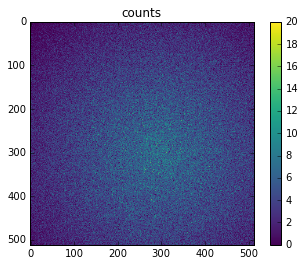

In [7]:
plt.title('values')
plt.imshow(curr_values, cmap='viridis')
plt.colorbar()

plt.figure(2)
plt.title('counts')
plt.imshow(curr_counts, cmap='viridis')
plt.colorbar()